<a href="https://colab.research.google.com/github/datdiego/qubit_dyamics/blob/main/benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install qutip
!pip install qutip-qtrl
!pip install qutip-qip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi
import qutip as qt
import pandas as pd
from qutip import *
from qutip_qtrl import *
from qutip_qip.operations import *
from numpy import pi
from qutip_qtrl.grape import plot_grape_control_fields, _overlap
from qutip_qtrl.cy_grape import cy_overlap
from qutip_qtrl.grape import cy_grape_unitary, grape_unitary_adaptive
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def calculate_theta_phi(unitary):
    """
    Calculate θ (polar angle) and φ (azimuthal angle) from a single-qubit unitary matrix.

    Parameters:
        unitary (numpy.ndarray): 2x2 unitary matrix.

    Returns:
        tuple: θ (in radians), φ (in radians)
    """
    # Extract the first column (assumed to represent the transformed |0⟩ state)
    a = unitary[0, 0]
    c = unitary[1, 0]

    # Compute the amplitude |a| and |c| to determine θ
    amplitude_a = np.abs(a)
    amplitude_c = np.abs(c)

    # Calculate θ
    theta = 2 * np.arctan2(amplitude_c, amplitude_a)  # Use arctan2 for full range [0, 2π]

    # Calculate φ
    phi = np.angle(c) - np.angle(a)
    phi = phi % (2 * np.pi)  # Normalize φ to [0, 2π]

    return theta, phi


In [ ]:
# Generate a test unitary
theta_test = 5.492699699351695
phi_test = 1.8754380361614587
U_test = rz(phi_test) * rx(theta_test)

print(U_test.full())

# Calculate θ and φ from the unitary
theta_calculated, phi_calculated = calculate_theta_phi(U_test.full())
print(f"Generated θ: {theta_test:.4f}, Calculated θ: {theta_calculated:.4f}")
print(f"Generated φ: {phi_test:.4f}, Calculated φ: {phi_calculated:.4f}")

[[-0.54601579+0.74405436j -0.31041715-0.22779608j]
 [ 0.31041715-0.22779608j -0.54601579-0.74405436j]]
Generated θ: 5.4927, Calculated θ: 0.7905
Generated φ: 1.8754, Calculated φ: 3.4462


# QuTip Data

In [ ]:
start_time = time.time()
# Define parameters
num_time_slices = 100  # Number of time slices for each GRAPE run
evo_time = 1.0  # Total evolution time
t_list = np.linspace(0, evo_time, num_time_slices)  # Time range
eps = 2 * np.pi / evo_time  # Epsilon scaling for GRAPE

# Define Hamiltonian components
H0 = 0 * np.pi * sigmaz()  # Drift Hamiltonian set to zero
H_ops = [sigmax(), sigmay(), sigmaz()]  # Control operators for x, y, and z directions
R =150

# Define the initial state (always starting from |0⟩)
psi0 = basis(2, 0)

theta_test = 0.9134
phi_test = 2.1354
# random angles
#theta_test = np.random.uniform(0, 2 * np.pi)
#phi_test = np.random.uniform(0, 2 * np.pi)

t_list = np.linspace(0, 1, 100)  # Time grid over 1 second

U = rz(phi_test) * rx(theta_test); U

# Initial guess for control fields with smoothing
u0 = np.array([np.random.rand(len(t_list)) * 2 * np.pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

# Run cy_grape_unitary to find the optimal control fields for reaching the target unitary
result = cy_grape_unitary(
    U, H0, H_ops, R, t_list, u_start=u0, eps=eps,
        phase_sensitive=False
    )

# Solve for dynamics to get expectation values ⟨σx⟩, ⟨σy⟩, and ⟨σz⟩ over time
e_ops = [sigmax(), sigmay(), sigmaz()]
me_result = mesolve(result.H_t, psi0, t_list, c_ops=[], e_ops=e_ops)

qutip_execution_time = time.time() - start_time
print(f"QuTiP execution time: {qutip_execution_time} seconds")

QuTiP execution time: 20.08803915977478 seconds


In [ ]:
print(phi_test)
print(theta_test)

2.1354
0.9134


In [ ]:
U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.43272721-0.78630535j -0.38634753-0.21261853j]
 [ 0.38634753-0.21261853j  0.43272721+0.78630535j]]

In [ ]:
# Extract QuTiP control fields and expectation values
last_iteration_u = result.u[-1]
qutip_control_fields = last_iteration_u   # Shape: (150, 3, 100)
qutip_expectations = np.array(me_result.expect)  # Shape: (3, 100)

In [ ]:
print("Shape of QuTiP control fields:", qutip_control_fields.shape) # (3, 100)
print("Shape of QuTiP expectation values:", qutip_expectations.shape) # (3, 100)

Shape of QuTiP control fields: (3, 100)
Shape of QuTiP expectation values: (3, 100)


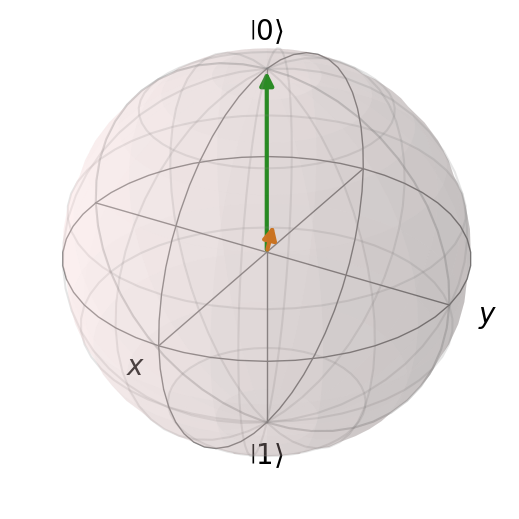

In [ ]:
init_bloch = Bloch()
init_bloch.add_states(psi0)
#init_bloch.add_points(qutip_expectations, meth='m', colors='b')
init_bloch.add_states(U*psi0)
init_bloch.show()

# Load Models

In [ ]:
# load model from drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        # Shared input layer
        self.fc_input = nn.Linear(3, 256)  # Input: θ, φ, t

        # Sub-network for control fields
        self.control_fc1 = nn.Linear(256, 128)
        self.control_fc2 = nn.Linear(128, 64)
        self.control_fc3 = nn.Linear(64, 32)
        self.control_fc4 = nn.Linear(32, 16)
        self.control_output = nn.Linear(16, 3)  # Output: u_x, u_y, u_z

        # Sub-network for expectation values
        self.expect_fc1 = nn.Linear(256, 128)
        self.expect_fc2 = nn.Linear(128, 64)
        self.expect_fc3 = nn.Linear(64, 32)
        self.expect_fc4 = nn.Linear(32, 16)
        self.expect_output = nn.Linear(16, 3)  # Output: ⟨σx⟩, ⟨σy⟩, ⟨σz⟩

    def forward(self, x):
        # Shared input processing
        shared = torch.relu(self.fc_input(x))

        # Control field prediction
        control = torch.relu(self.control_fc1(shared))
        control = torch.relu(self.control_fc2(control))
        control = torch.relu(self.control_fc3(control))
        control = torch.relu(self.control_fc4(control))
        control = self.control_output(control)

        # Expectation value prediction
        expect = torch.relu(self.expect_fc1(shared))
        expect = torch.relu(self.expect_fc2(expect))
        expect = torch.relu(self.expect_fc3(expect))
        expect = torch.relu(self.expect_fc4(expect))
        expect = self.expect_output(expect)

        # Concatenate outputs
        return torch.cat((control, expect), dim=1)  # Shape: (batch_size, 6)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pinn_model = PINN()

In [ ]:
# Load model with map_location to CPU
state_dict = torch.load('/content/drive/MyDrive/quantum/model/OptQuPINN_phyloss_11-16.pth', map_location=torch.device('cpu'))
pinn_model.load_state_dict(state_dict)

<ipython-input-59-771308d98874>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/quantum/model/OptQuPINN_phyloss_11-16.pth', 

<All keys matched successfully>

In [ ]:
class QubiNN(nn.Module):
    def __init__(self):
        super(QubiNN, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Input: θ, φ, t
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 6)  # Output: u_x, u_y, u_z, ⟨σx⟩, ⟨σy⟩, ⟨σz⟩

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc_out(x)
        return x


In [ ]:
qubi_model = QubiNN()


In [ ]:
state_dict_qubinn = torch.load('/content/drive/MyDrive/quantum/model/qubi_nn_model_11-15.pth', map_location=torch.device('cpu'))
qubi_model.load_state_dict(state_dict_qubinn)

<ipython-input-62-c966efca86cd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_qubinn = torch.load('/content/drive/MyDrive/quantum/model/qubi_nn_model_11-15.pth

<All keys matched successfully>

In [ ]:
# Prepare inputs for the PINN
theta_test_normalized = theta_test / (2 * np.pi)  # Normalize θ
phi_test_normalized = phi_test / (2 * np.pi)      # Normalize φ
pinn_inputs = np.array([[theta_test_normalized, phi_test_normalized, t] for t in t_list], dtype=np.float32)

# Convert inputs to PyTorch tensor
pinn_inputs_tensor = torch.tensor(pinn_inputs, device=device)

In [ ]:
start_time = time.time()
# Predict using the PINN
pinn_model.eval()
with torch.no_grad():
    pinn_outputs = pinn_model(pinn_inputs_tensor).cpu().numpy()  # Shape: (100, 6)

pinn_execution_time = time.time() - start_time
print(f"PINN execution time: {pinn_execution_time} seconds")

PINN execution time: 0.008208990097045898 seconds


In [ ]:
# Calculate speedup
speedup = qutip_execution_time / pinn_execution_time

# Print speedup
print(f"Speedup of PINN over QuTiP Simulation: {speedup:.2f}x")

Speedup of PINN over QuTiP Simulation: 2447.08x


In [ ]:
start_time = time.time()
# Predict using the PINN
qubi_model.eval()
with torch.no_grad():
    qubinn_outputs = qubi_model(pinn_inputs_tensor).cpu().numpy()  # Shape: (100, 6)

qubinn_execution_time = time.time() - start_time
print(f"QubiNN execution time: {qubinn_execution_time} seconds")

QubiNN execution time: 0.008208990097045898 seconds


In [ ]:
# Calculate speedup
speedup = qutip_execution_time / qubinn_execution_time

# Print speedup
print(f"Speedup of QubiNN over QuTiP Simulation: {speedup:.2f}x")

Speedup of QubiNN over QuTiP Simulation: 6955.78x


# Charts

In [ ]:
# Extract control fields and expectation values
pinn_control_fields = pinn_outputs[:, :3].T  # u_x, u_y, u_z (Shape: (3, 100))
pinn_expectations = pinn_outputs[:, 3:].T    # ⟨σx⟩, ⟨σy⟩, ⟨σz⟩ (Shape: (3, 100))

In [ ]:
# Extract control fields and expectation values
qubinn_control_fields = qubinn_outputs[:, :3].T  # u_x, u_y, u_z (Shape: (3, 100))
qubinn_expectations = qubinn_outputs[:, 3:].T    # ⟨σx⟩, ⟨σy⟩, ⟨σz⟩ (Shape: (3, 100))

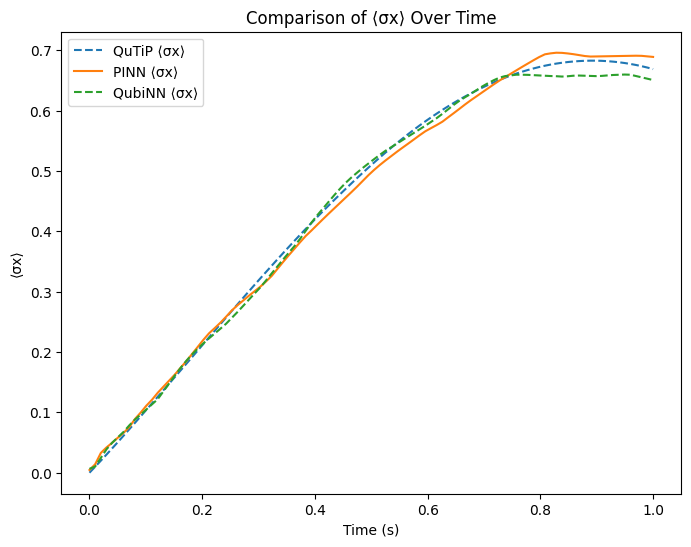

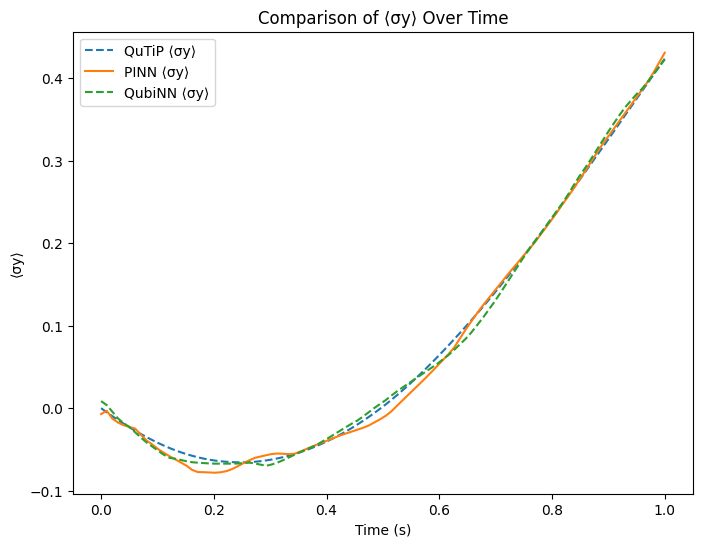

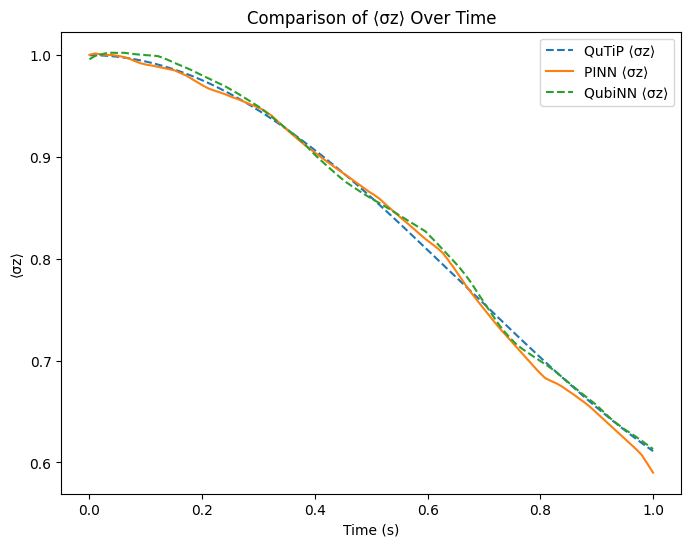

In [ ]:
import matplotlib.pyplot as plt

expectations = ['⟨σx⟩', '⟨σy⟩', '⟨σz⟩']
for i, label in enumerate(expectations):
    plt.figure(figsize=(8, 6))
    plt.plot(t_list, qutip_expectations[i], label=f'QuTiP {label}', linestyle='--')
    plt.plot(t_list, pinn_expectations[i], label=f'PINN {label}', linestyle='-')
    plt.plot(t_list, qubinn_expectations[i], label=f'QubiNN {label}', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel(label)
    plt.title(f'Comparison of {label} Over Time')
    plt.legend()
    plt.show()


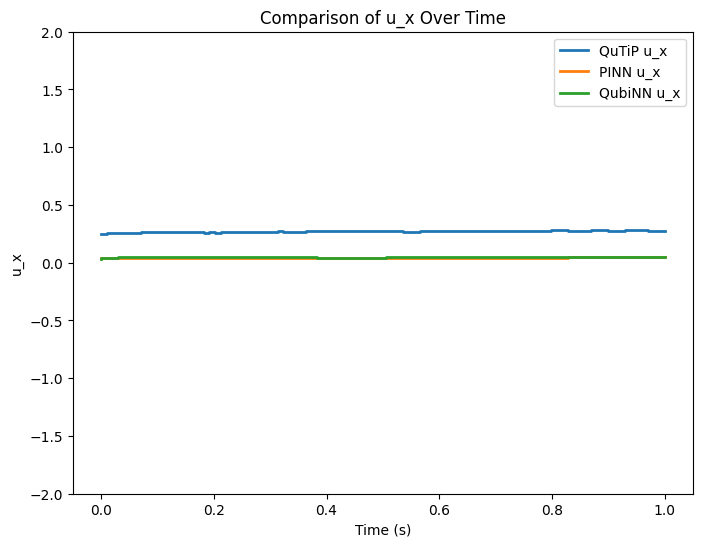

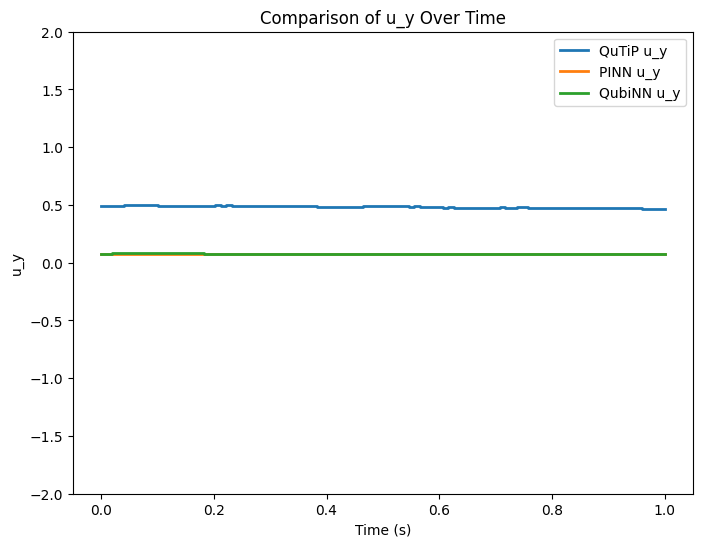

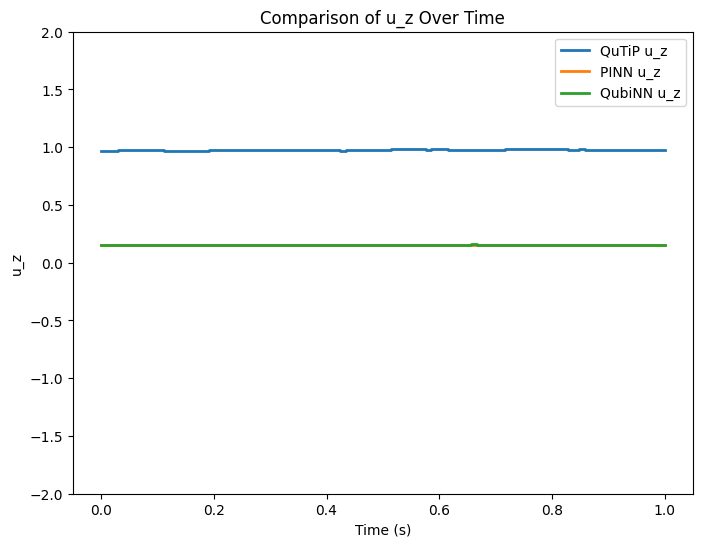

In [ ]:
fields = ['u_x', 'u_y', 'u_z']
for i, field in enumerate(fields):
    plt.figure(figsize=(8, 6))
    lw, lc, alpha = 2.0, 'k', 1.0


    plt.step(t_list, qutip_control_fields[i], label=f'QuTiP {field}', linestyle='-', lw=lw, alpha=alpha)
    plt.step(t_list, pinn_control_fields[i], label=f'PINN {field}', linestyle='-', lw=lw, alpha=alpha)
    plt.step(t_list, qubinn_control_fields[i], label=f'QubiNN {field}', linestyle='-', lw=lw, alpha=alpha)

    #plt.plot(t_list, qutip_control_fields[i], label=f'QuTiP {field}', linestyle='--')
    #plt.plot(t_list, pinn_control_fields[i], label=f'PINN {field}', linestyle='-')
    #plt.plot(t_list, qubinn_control_fields[i], label=f'QubiNN {field}', linestyle=':')
    plt.xlabel('Time (s)')
    plt.ylabel(field)
    # set standard y axis
    plt.ylim(-2, 2)

    plt.title(f'Comparison of {field} Over Time')
    plt.legend()
    plt.show()

In [ ]:
def calculate_density_matrix(sigma_x, sigma_y, sigma_z):
    """
    Calculate the density matrix from expectation values.

    Parameters:
        sigma_x (float): Expectation value of ⟨σx⟩.
        sigma_y (float): Expectation value of ⟨σy⟩.
        sigma_z (float): Expectation value of ⟨σz⟩.

    Returns:
        numpy.ndarray: The density matrix (2x2).
    """
    rho = np.array([
        [1 + sigma_z, sigma_x - 1j * sigma_y],
        [sigma_x + 1j * sigma_y, 1 - sigma_z]
    ]) / 2
    return rho

In [ ]:
rho_qutip = calculate_density_matrix(qutip_expectations[0][-1], qutip_expectations[1][-1], qutip_expectations[2][-1])
rho_qutip_state = Qobj(rho_qutip)
rho_pinn = calculate_density_matrix(pinn_expectations[0][-1], pinn_expectations[1][-1], pinn_expectations[2][-1])
rho_pinn_state = Qobj(rho_pinn)
rho_qubinn = calculate_density_matrix(qubinn_expectations[0][-1], qubinn_expectations[1][-1], qubinn_expectations[2][-1])
rho_qubinn_state = Qobj(rho_qubinn)

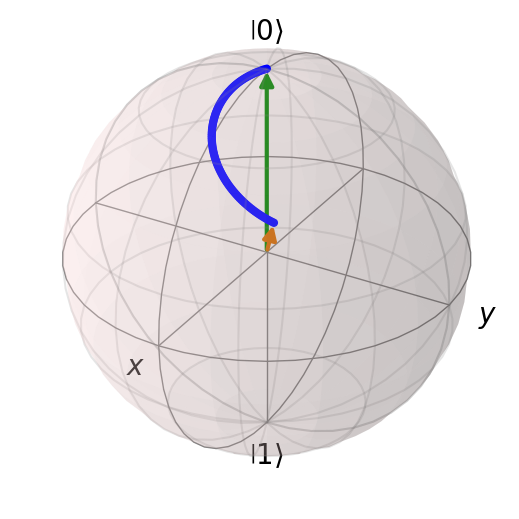

In [ ]:
# Create Bloch sphere for QuTiP data
b_qutip = Bloch()
b_qutip.add_states(psi0)
b_qutip.add_points([qutip_expectations[0], qutip_expectations[1], qutip_expectations[2]], meth='m', colors='b')
b_qutip.add_states(rho_qutip_state)
b_qutip.show()

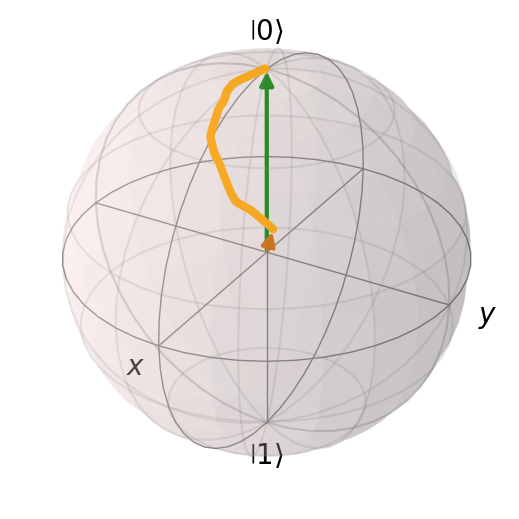

In [ ]:
b_pinn = Bloch()
b_pinn.add_points([pinn_expectations[0], pinn_expectations[1], pinn_expectations[2]], meth='m', colors='orange')
b_pinn.add_states(psi0)
b_pinn.add_states(rho_pinn_state)
b_pinn.show()

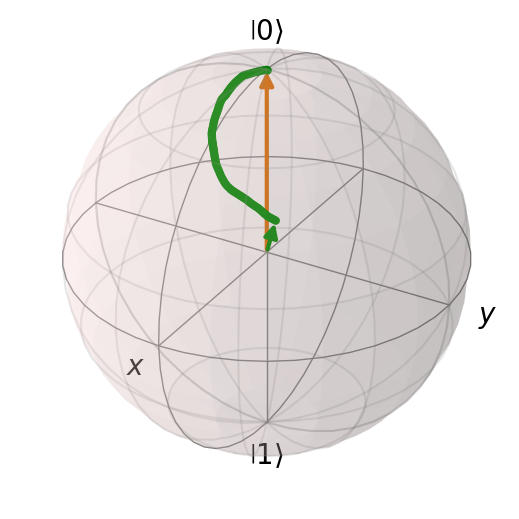

In [ ]:
b_qubinn= Bloch()
b_qubinn.add_points([qubinn_expectations[0], qubinn_expectations[1], qubinn_expectations[2]], meth='m', colors='g')
b_qubinn.add_states(rho_qubinn_state)
b_qubinn.add_states(psi0)
b_qubinn.show()

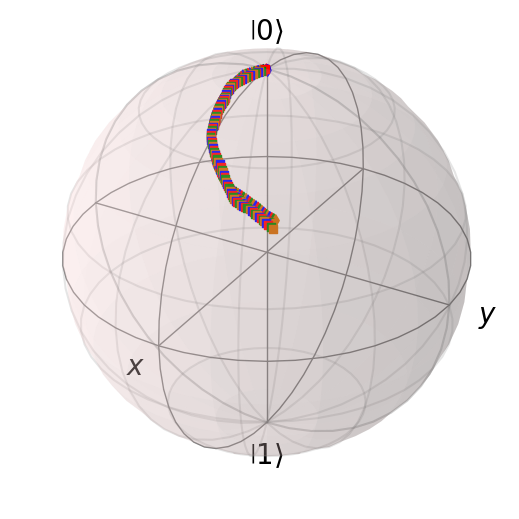

In [ ]:
b_all = Bloch()
b_all.add_points([qutip_expectations[0], qutip_expectations[1], qutip_expectations[2]], meth='m')
b_all.add_points([pinn_expectations[0], pinn_expectations[1], pinn_expectations[2]], meth='m')
b_all.add_points([qubinn_expectations[0], qubinn_expectations[1], qubinn_expectations[2]], meth='m')
b_all.show()


# MSE

In [ ]:
from sklearn.metrics import mean_squared_error

# MSE for expectation values
mse_sigmax = mean_squared_error(qutip_expectations[0], pinn_expectations[0])
mse_sigmay = mean_squared_error(qutip_expectations[1], pinn_expectations[1])
mse_sigmaz = mean_squared_error(qutip_expectations[2], pinn_expectations[2])

print(f"MSE for ⟨σx⟩: {mse_sigmax:.6f}")
print(f"MSE for ⟨σy⟩: {mse_sigmay:.6f}")
print(f"MSE for ⟨σz⟩: {mse_sigmaz:.6f}")

# MSE for control fields
mse_ux = mean_squared_error(qutip_control_fields[0], pinn_control_fields[0])
mse_uy = mean_squared_error(qutip_control_fields[1], pinn_control_fields[1])
mse_uz = mean_squared_error(qutip_control_fields[2], pinn_control_fields[2])

print(f"MSE for u_x: {mse_ux:.6f}")
print(f"MSE for u_y: {mse_uy:.6f}")
print(f"MSE for u_z: {mse_uz:.6f}")

MSE for ⟨σx⟩: 0.000141
MSE for ⟨σy⟩: 0.000053
MSE for ⟨σz⟩: 0.000048
MSE for u_x: 0.051476
MSE for u_y: 0.165733
MSE for u_z: 0.674300


In [ ]:
from sklearn.metrics import mean_squared_error

# MSE for expectation values
mse_sigmax = mean_squared_error(qutip_expectations[0], qubinn_expectations[0])
mse_sigmay = mean_squared_error(qutip_expectations[1], qubinn_expectations[1])
mse_sigmaz = mean_squared_error(qutip_expectations[2], qubinn_expectations[2])

print(f"MSE for ⟨σx⟩: {mse_sigmax:.6f}")
print(f"MSE for ⟨σy⟩: {mse_sigmay:.6f}")
print(f"MSE for ⟨σz⟩: {mse_sigmaz:.6f}")

# MSE for control fields
mse_ux = mean_squared_error(qutip_control_fields[0], qubinn_expectations[0])
mse_uy = mean_squared_error(qutip_control_fields[1], qubinn_expectations[1])
mse_uz = mean_squared_error(qutip_control_fields[2], qubinn_expectations[2])

print(f"MSE for u_x: {mse_ux:.6f}")
print(f"MSE for u_y: {mse_uy:.6f}")
print(f"MSE for u_z: {mse_uz:.6f}")

MSE for ⟨σx⟩: 0.000134
MSE for ⟨σy⟩: 0.000043
MSE for ⟨σz⟩: 0.000040
MSE for u_x: 0.072973
MSE for u_y: 0.192577
MSE for u_z: 0.034769


# Fidelity

In [ ]:
import numpy as np

def compute_fidelity_per_component(true_array, predicted_array):
    """
    Compute fidelity for each component (e.g., u_x, u_y, u_z or ⟨σx⟩, ⟨σy⟩, ⟨σz⟩)
    across all time steps.

    Parameters:
        true_array (numpy.ndarray): Ground truth values, shape (3, time_steps).
        predicted_array (numpy.ndarray): Predicted values, shape (3, time_steps).

    Returns:
        dict: A dictionary where keys are component names ('u_x', 'u_y', etc.)
              and values are the corresponding fidelity values.
    """
    assert true_array.shape == predicted_array.shape, "Shape mismatch between true and predicted arrays"

    # Number of components (3: u_x, u_y, u_z or ⟨σx⟩, ⟨σy⟩, ⟨σz⟩)
    num_components = true_array.shape[0]
    component_names = [f"Component_{i}" for i in range(1, num_components + 1)]  # Default names

    # Fidelity calculation for each component
    fidelities = {}
    for i, name in enumerate(component_names):
        true_vector = true_array[i, :]
        predicted_vector = predicted_array[i, :]

        # Compute norms
        true_norm = np.linalg.norm(true_vector)
        pred_norm = np.linalg.norm(predicted_vector)

        if true_norm > 0 and pred_norm > 0:
            # Fidelity is cosine similarity squared
            fidelity_computed = (np.dot(true_vector, predicted_vector) / (true_norm * pred_norm)) ** 2
        else:
            # Handle zero-norm vectors
            fidelity_computed = 0.0

        fidelities[name] = fidelity_computed

    return fidelities


In [ ]:
expectations = ['⟨σx⟩', '⟨σy⟩', '⟨σz⟩']
pinn_expec_fidelity = compute_fidelity_per_component(qutip_expectations, pinn_expectations)
qubinn_expec_fidelity = compute_fidelity_per_component(qutip_expectations, qubinn_expectations)

# print each fidelity with label from expecations
for i in range(len(expectations)):
    label = expectations[i]
    pinn_fidelity = pinn_expec_fidelity[f"Component_{i+1}"]
    print(f"Fidelity for {label} (PINN): {pinn_fidelity}")
print("")
# print each fidelity with label from expecations
for i in range(len(expectations)):
    label = expectations[i]
    qubinn_fidelity = qubinn_expec_fidelity[f"Component_{i+1}"]
    print(f"Fidelity for {label} (QubiNN): {qubinn_fidelity}")

Fidelity for ⟨σx⟩ (PINN): 0.9994360811651479
Fidelity for ⟨σy⟩ (PINN): 0.9981868619564002
Fidelity for ⟨σz⟩ (PINN): 0.9999374107473255

Fidelity for ⟨σx⟩ (QubiNN): 0.9996521348908726
Fidelity for ⟨σy⟩ (QubiNN): 0.9985633110710916
Fidelity for ⟨σz⟩ (QubiNN): 0.999953194426977


In [ ]:
controls = ['u_x', 'u_y', 'u_z']
pinn_control_fidelity = compute_fidelity_per_component(qutip_control_fields, pinn_control_fields)
qubinn_control_fidelity = compute_fidelity_per_component(qutip_control_fields, qubinn_control_fields)

for i in range(len(controls)):
    label = controls[i]
    pinn_fidelity = pinn_control_fidelity[f"Component_{i+1}"]
    print(f"Fidelity for {label} (PINN): {pinn_fidelity}")
print("")

for i in range(len(controls)):
    label = controls[i]
    qubinn_fidelity = qubinn_control_fidelity[f"Component_{i+1}"]
    print(f"Fidelity for {label} (QubiNN): {qubinn_fidelity}")


Fidelity for u_x (PINN): 0.9998269269397423
Fidelity for u_y (PINN): 0.9989831367322368
Fidelity for u_z (PINN): 0.9999206161844493

Fidelity for u_x (QubiNN): 0.998161154314177
Fidelity for u_y (QubiNN): 0.9993465739627388
Fidelity for u_z (QubiNN): 0.9998922108698337


In [ ]:
# prompt: Plot the control fidelity in charts

# Plotting code is already present in the provided code.
# No further code is needed to generate the plots.
# The code will plot the control fidelity and expectation values.

In [ ]:
def calculate_density_matrix(sigma_x, sigma_y, sigma_z):
    """
    Calculate the density matrix from expectation values.

    Parameters:
        sigma_x (float): Expectation value of ⟨σx⟩.
        sigma_y (float): Expectation value of ⟨σy⟩.
        sigma_z (float): Expectation value of ⟨σz⟩.

    Returns:
        numpy.ndarray: The density matrix (2x2).
    """
    rho = np.array([
        [1 + sigma_z, sigma_x - 1j * sigma_y],
        [sigma_x + 1j * sigma_y, 1 - sigma_z]
    ]) / 2
    return rho

In [ ]:
# calculate rho of the last expected values of the pinn
rho_pinn = calculate_density_matrix(pinn_expectations[0][-1], pinn_expectations[1][-1], pinn_expectations[2][-1])

# convert to qutip object
rho_pinn_q = Qobj(rho_pinn)

In [ ]:
print(rho_pinn_q)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.79495093+0.j        0.34446105-0.2154253j]
 [0.34446105+0.2154253j 0.20504907+0.j       ]]


In [ ]:
print(U*psi0)

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.43272721-0.78630535j]
 [0.38634753-0.21261853j]]


In [ ]:
from qutip import fidelity # Make sure to import the 'fidelity' function


In [ ]:
f = fidelity(rho_pinn_q, U*psi0)
print(f)

1.0009148061438777


In [ ]:
# calculate rho of the last expected values of the pinn
rho_q = calculate_density_matrix(qubinn_expectations[0][-1], qubinn_expectations[1][-1], qubinn_expectations[2][-1])

# convert to qutip object
rho_qubinn = Qobj(rho_q)

In [ ]:
fq = fidelity(rho_qubinn, U*psi0)
print(fq)

0.9971881150620225
